In [130]:
import yfinance as yf
import pandas as pd

# Define the list of ticker symbols for the companies
companies = {
    'Nike': 'NKE',
    'Goldman Sachs': 'GS',
    'Johnson & Johnson': 'JNJ',
    'Pfizer': 'PFE',
    'JP Morgan': 'JPM'
}


# Define the start and end dates
start_date = '2014-04-05'
end_date = '2024-04-05'

# Fetch data for each company and store in a dictionary of DataFrames
data = {}
for company, ticker in companies.items():
    data[company] = yf.download(ticker, start=start_date, end=end_date)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [131]:
# Example: Access Nike's data
print(data['Pfizer'].columns)

MultiIndex([('Adj Close', 'PFE'),
            (    'Close', 'PFE'),
            (     'High', 'PFE'),
            (      'Low', 'PFE'),
            (     'Open', 'PFE'),
            (   'Volume', 'PFE')],
           names=['Price', 'Ticker'])


In [132]:
# Define a function to add new variables
def add_features(df):
    df['H-L'] = df['High'] - df['Low']                    # High - Low
    df['O-C'] = df['Close'] - df['Open']                  # Close - Open
    df['7D_MA'] = df['Close'].rolling(window=7).mean()    # 7-day moving average of Close
    df['14D_MA'] = df['Close'].rolling(window=14).mean()  # 14-day moving average of Close
    df['21D_MA'] = df['Close'].rolling(window=21).mean()  # 21-day moving average of Close
    df['7D_STD'] = df['Close'].rolling(window=7).std()    # 7-day standard deviation of Close
    return df

# Apply the feature engineering function to each DataFrame
for company, df in data.items():
    data[company] = add_features(df).dropna()  # Drop NaN rows after rolling calculations


In [133]:
# Example: Preview Nike's data with the new features
print(data['Pfizer'].head())

Price                      Adj Close      Close       High        Low  \
Ticker                           PFE        PFE        PFE        PFE   
Date                                                                    
2014-05-06 00:00:00+00:00  18.622276  27.922201  28.472486  27.827324   
2014-05-07 00:00:00+00:00  18.526522  27.533207  27.969639  27.371918   
2014-05-08 00:00:00+00:00  18.622280  27.675522  27.931688  27.495256   
2014-05-09 00:00:00+00:00  18.532902  27.542694  27.713472  27.296015   
2014-05-12 00:00:00+00:00  18.596741  27.637571  27.874763  27.542694   

Price                           Open    Volume       H-L       O-C      7D_MA  \
Ticker                           PFE       PFE                                  
Date                                                                            
2014-05-06 00:00:00+00:00  28.462997  57674669  0.645163 -0.540796  29.326376   
2014-05-07 00:00:00+00:00  27.647058  51703338  0.597721 -0.113852  28.917051   
2014-05-08

In [134]:
# Define the split dates
train_end_date = '2021-04-03'
test_start_date = '2021-04-04'

# Split each company's data and store as separate DataFrames
for company, df in data.items():
    # Training data: all rows before the training end date
    train_data = df[df.index <= train_end_date]
    # Testing data: all rows from the testing start date onwards
    test_data = df[df.index >= test_start_date]

    # Store split data in dictionary
    data[company] = {'Train': train_data, 'Test': test_data}

# Example: Preview the training and testing sets for Nike
# print("Nike Training Set")
# print(data['Nike']['Train'].head())
# print("\nNike Testing Set")
# print(data['Nike']['Test'].head())


In [135]:
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler
scaler = MinMaxScaler()

# Scale each company's training and testing data
for company, sets in data.items():
    # Fit the scaler on the training data (to learn the scaling parameters)
    train_data_scaled = scaler.fit_transform(sets['Train'])
    # Transform the training and testing data using the same scaler
    data[company]['Train'] = pd.DataFrame(train_data_scaled,
                                          columns=sets['Train'].columns,
                                          index=sets['Train'].index)

    test_data_scaled = scaler.transform(sets['Test'])
    data[company]['Test'] = pd.DataFrame(test_data_scaled,
                                         columns=sets['Test'].columns,
                                         index=sets['Test'].index)

# Example: Preview scaled data for Nike
# print("Nike Scaled Training Set")
# print(data['Nike']['Train'].head())
# print("\nNike Scaled Testing Set")
# print(data['Nike']['Test'].head())


In [136]:
# Define dictionaries to store training and testing data for each company
X_train_dict = {}
y_train_dict = {}
X_test_dict = {}
y_test_dict = {}

# Loop through each company to extract training and testing data
for company, sets in data.items():
    # Define X (features) and y (target) for training and testing for each company
    train_data = sets['Train']
    test_data = sets['Test']

    # Selecting the features for X and the target 'Close' for y
    # X_train_dict[company] = train_data[['H-L', 'O-C', '7D_MA', '14D_MA', '21D_MA', '7D_STD', 'Volume']].to_numpy()
    # y_train_dict[company] = train_data['Close'].to_numpy()
    # X_test_dict[company] = test_data[['H-L', 'O-C', '7D_MA', '14D_MA', '21D_MA', '7D_STD', 'Volume']].to_numpy()
    # y_test_dict[company] = test_data['Close'].to_numpy()

    X_train_dict[company] = train_data[['H-L', 'O-C', '7D_MA', '14D_MA', '21D_MA', '7D_STD', 'Volume']].to_numpy()
    y_train_dict[company] = train_data['Close'].to_numpy()
    X_test_dict[company] = test_data[['H-L', 'O-C', '7D_MA', '14D_MA', '21D_MA', '7D_STD', 'Volume']].to_numpy()
    y_test_dict[company] = test_data['Close'].to_numpy()
# Now X_train_dict, y_train_dict, X_test_dict, and y_test_dict contain data for all companies


In [137]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error


In [138]:
def build_ann_model(input_shape):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(input_shape,)))  # Hidden layer with ReLU activation
    model.add(Dense(1))  # Output layer for regression, linear activation by default
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mae'])
    return model


In [139]:
# Loop through each company to train and evaluate the ANN model
results = {}
input_shape = 7  # Number of features used as input

for company in X_train_dict.keys():
    print(f"\nTraining ANN model for {company}...")

    # Get the training and testing data for the current company
    X_train = X_train_dict[company]
    y_train = y_train_dict[company]
    X_test = X_test_dict[company]
    y_test = y_test_dict[company]

    # Build and train the model
    ann_model = build_ann_model(input_shape)
    history = ann_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

    # Predict on the test set
    y_pred = ann_model.predict(X_test)

    # Calculate RMSE, MAPE, and MBE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)
    mbe = np.mean(y_test - y_pred)  # MBE calculation

    # Store the results
    results[company] = {'RMSE': rmse, 'MAPE': mape, 'MBE': mbe, 'y_pred': y_pred.flatten()}
    print(f"{company} - RMSE: {rmse:.4f}, MAPE: {mape:.4%}, MBE: {mbe:.4f}")

# Display the results for each company
print("\nFinal Results:")
for company, metrics in results.items():
    print(f"{company}: RMSE = {metrics['RMSE']:.4f}, MAPE = {metrics['MAPE']:.4%}, MBE = {metrics['MBE']:.4f}")



Training ANN model for Nike...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Nike - RMSE: 0.0645, MAPE: 5.3830%, MBE: 0.0431

Training ANN model for Goldman Sachs...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Goldman Sachs - RMSE: 0.0453, MAPE: 3.5051%, MBE: 0.0267

Training ANN model for Johnson & Johnson...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Johnson & Johnson - RMSE: 0.0563, MAPE: 4.4962%, MBE: 0.0412

Training ANN model for Pfizer...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Pfizer - RMSE: 0.0711, MAPE: 11.6738%, MBE: 0.0132

Training ANN model for JP Morgan...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
JP Morgan - RMSE: 0.0344, MAPE: 2.8079%, MBE: 0.0177

Final Results:
Nike: RMSE = 0.0645, MAPE = 5.3830%, MBE = 0.0431
Goldman Sachs: RMSE = 0.0453, MAPE = 3.5051%, MBE = 0.0267
Johnson & Johnson: RMSE = 0.0563, MAPE = 4.4962%, MBE = 0.0412
Pfizer: RMSE = 0.0711, MAPE = 11.6738%, MBE = 0.0132
JP Morgan: RMSE = 0.0344, MAPE = 2.8079%, MBE = 0.0177


In [140]:
from sklearn.model_selection import GridSearchCV

# Define a parameter grid for the hyperparameters
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


In [141]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Dictionary storing the best parameters for each company
best_params = {
    'Nike': {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100},
    'Goldman Sachs': {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50},
    'Johnson & Johnson': {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50},
    'Pfizer': {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50},
    'JP Morgan': {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
}

# Dictionary to store the results for each company
rf_results = {}

# Loop through each company and train Random Forest using the best parameters
for company, params in best_params.items():
    print(f"\nTraining Random Forest for {company} with best parameters...")

    # Extract training and testing data for the company
    X_train = X_train_dict[company]
    y_train = y_train_dict[company]
    X_test = X_test_dict[company]
    y_test = y_test_dict[company]

    # Initialize the Random Forest model with the best parameters
    rf_model = RandomForestRegressor(
        max_depth=params['max_depth'],
        min_samples_leaf=params['min_samples_leaf'],
        min_samples_split=params['min_samples_split'],
        n_estimators=params['n_estimators'],
        random_state=42
    )

    # Train the model on the training data
    rf_model.fit(X_train, y_train)

    # Predict on the test set
    y_pred_rf = rf_model.predict(X_test)

    # Calculate RMSE, MAPE, and MBE for evaluation
    rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
    mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)
    mbe_rf = np.mean(y_test - y_pred_rf)

    # Store results for the company
    rf_results[company] = {
        'model': rf_model,
        'RMSE': rmse_rf,
        'MAPE': mape_rf,
        'MBE': mbe_rf,
        'y_pred': y_pred_rf
    }

    print(f"{company} - RF RMSE: {rmse_rf:.4f}, MAPE: {mape_rf:.4%}, MBE: {mbe_rf:.4f}")



Training Random Forest for Nike with best parameters...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Nike - RF RMSE: 0.0984, MAPE: 7.4928%, MBE: 0.0169

Training Random Forest for Goldman Sachs with best parameters...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Goldman Sachs - RF RMSE: 0.1556, MAPE: 10.7262%, MBE: 0.0830

Training Random Forest for Johnson & Johnson with best parameters...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Johnson & Johnson - RF RMSE: 0.0830, MAPE: 6.0114%, MBE: 0.0405

Training Random Forest for Pfizer with best parameters...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pfizer - RF RMSE: 0.3229, MAPE: 23.3280%, MBE: 0.1966

Training Random Forest for JP Morgan with best parameters...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


JP Morgan - RF RMSE: 0.1004, MAPE: 6.1755%, MBE: 0.0332


In [142]:
import pandas as pd

# Combine ANN and RF results into a single DataFrame for comparison
comparison_df = pd.DataFrame({
    'Company': list(results.keys()),
    'ANN_RMSE': [results[company]['RMSE'] for company in results],
    'ANN_MAPE': [results[company]['MAPE'] for company in results],
    'ANN_MBE': [results[company]['MBE'] for company in results],
    'RF_RMSE': [rf_results[company]['RMSE'] for company in rf_results],
    'RF_MAPE': [rf_results[company]['MAPE'] for company in rf_results],
    'RF_MBE': [rf_results[company]['MBE'] for company in rf_results]
})

# Display the comparison table
print("Numerical Comparison of ANN and RF Models")
print(comparison_df)


Numerical Comparison of ANN and RF Models
             Company  ANN_RMSE  ANN_MAPE   ANN_MBE   RF_RMSE   RF_MAPE  \
0               Nike  0.064476  0.053830  0.043088  0.098425  0.074928   
1      Goldman Sachs  0.045256  0.035051  0.026713  0.155601  0.107262   
2  Johnson & Johnson  0.056306  0.044962  0.041174  0.083046  0.060114   
3             Pfizer  0.071137  0.116738  0.013161  0.322853  0.233280   
4          JP Morgan  0.034407  0.028079  0.017716  0.100389  0.061755   

     RF_MBE  
0  0.016853  
1  0.082992  
2  0.040467  
3  0.196638  
4  0.033197  


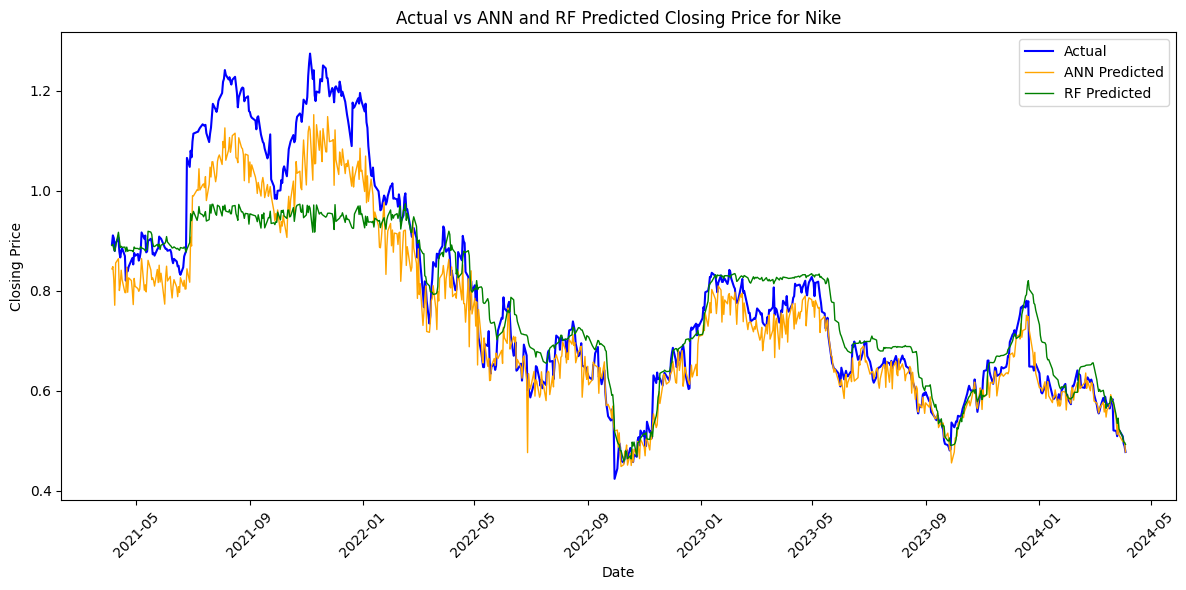

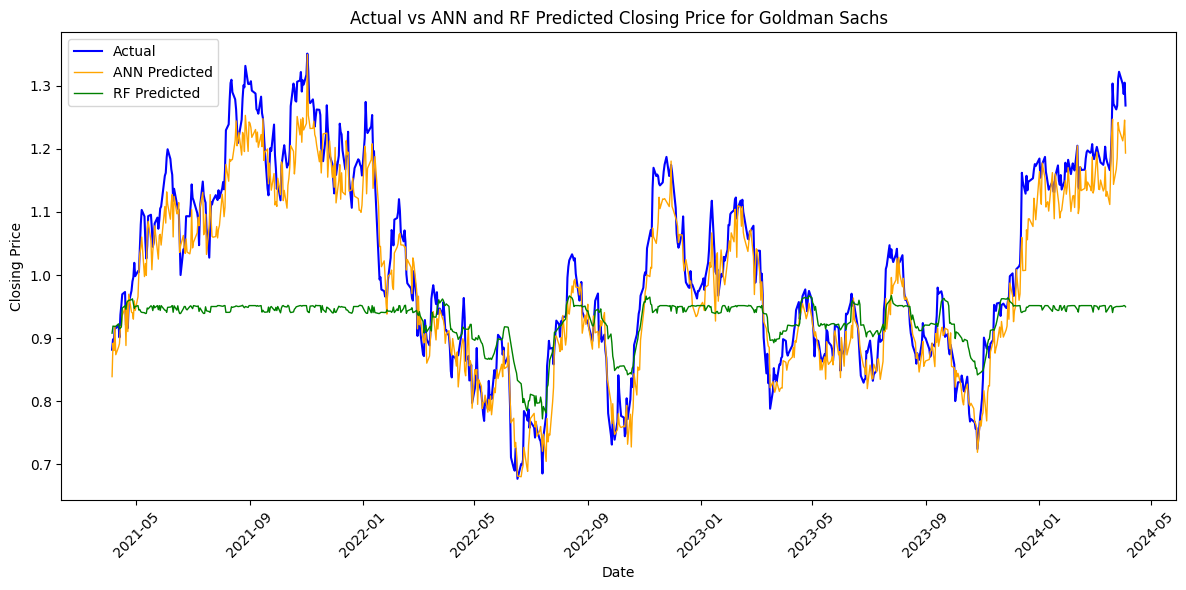

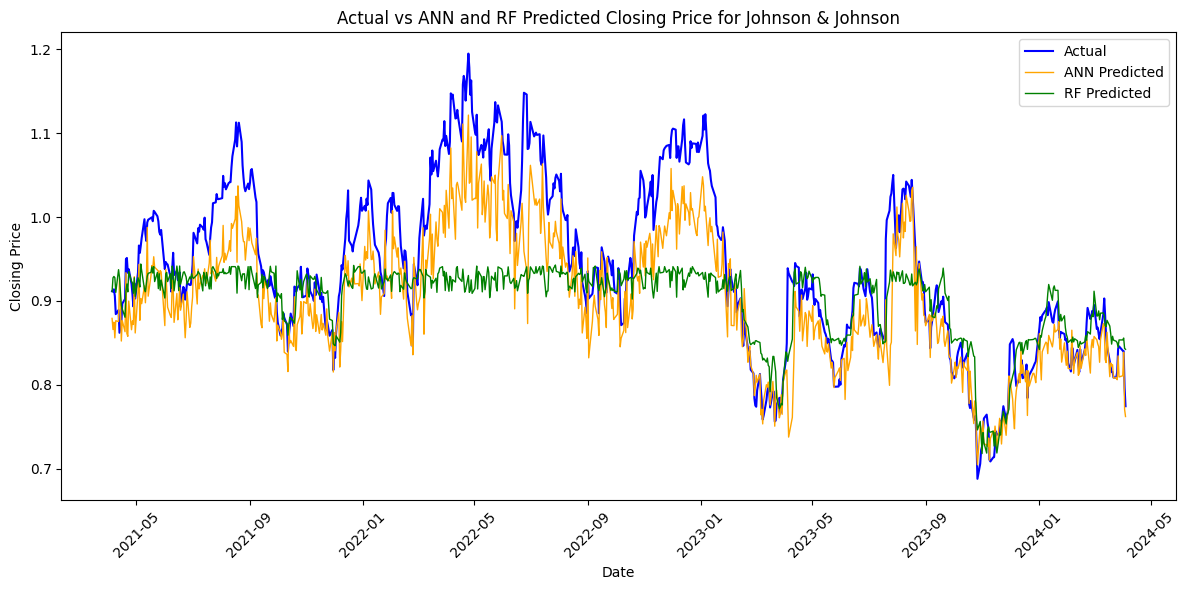

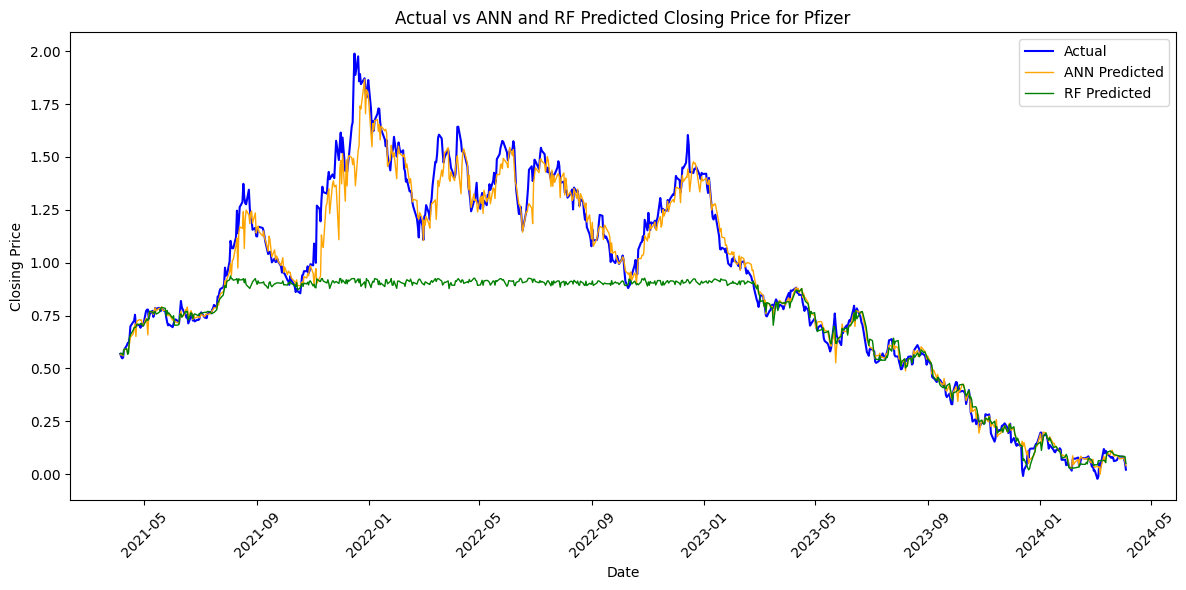

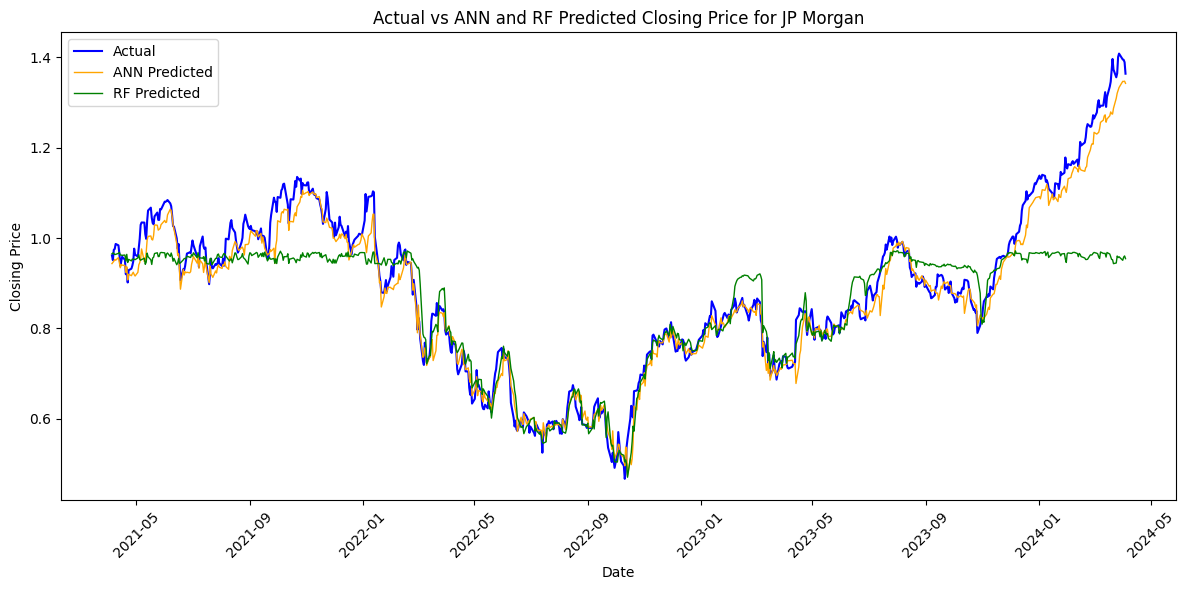

In [147]:
import matplotlib.pyplot as plt

# Plot actual vs ANN and RF predicted prices for each company on a single graph
for company in X_test_dict.keys():
    # Actual values
    y_actual = y_test_dict[company]

    # Get the dates for the x-axis from the test set
    dates = data[company]['Test'].index  # Assuming unscaled_data contains original dates

    # ANN and RF predictions
    ann_y_pred = results[company]['y_pred']
    rf_y_pred = rf_results[company]['y_pred']

    # Plot Actual, ANN Predicted, and RF Predicted Prices on a single graph
    plt.figure(figsize=(12, 6))
    plt.plot(dates, y_actual, label='Actual', color='blue', linewidth=1.5)
    plt.plot(dates, ann_y_pred, label='ANN Predicted', color='orange', linewidth=1)
    plt.plot(dates, rf_y_pred, label='RF Predicted', color='green', linewidth=1)
    plt.title(f"Actual vs ANN and RF Predicted Closing Price for {company}")
    plt.xlabel("Date")
    plt.ylabel("Closing Price")
    plt.legend()
    plt.xticks(rotation=45)  # Rotate dates for readability
    plt.tight_layout()       # Adjust layout for better spacing
    plt.show()
